## 1. Theory component 


Consider an undirected, unweighted graph $G=(V,E)$. 
For a node $u\in V$ we define the neighbors of $u$ to be all the neighbors of $u$ in $G$ and we denote it by 
$N(u)$. That is,

$$
N(u) = \{v\in V \mid (u,v)\in E\}.
$$

Now consider the neighborhood function of a set of nodes
$S\subseteq V$ defined as follows:

$$
\mathcal{N}(S) = \left|\cup_{v\in S} N(v) \right|.
$$


## 1.1 

Show that function $\mathcal{N}(S)$ is monotone.


**Proof:** <br>

$N(S)$ is monotone, if for all $A \subseteq B$, $N(A) \le N(B)$.

Since $A \subseteq B$, $B$ has the same vertices as $A$ along with some extra vertices. The common vertices contribute the same value to $N(A)$ and $N(B)$. <br>

If the extra vertices in B do not have any distinct neighbours, they do not contribute to $N(B)$ and, $N(A) = N(B)$. <br>

If the extra vertices have distinct neighbours then they contribute to $N(B)$ and, $N(A) < N(B)$.<br>

So, $N(A) \le N(B)$ and hence $N(S)$ is monotone.



## 1.2 


Show that function $\mathcal{N}(S)$ is submodular.

**Proof :** <br>

$N(S)$ is submodular if and only if for every $A \subseteq B \subseteq V$ , for every $i \in V$ \ $B: N_A(i) \geq N_B(i)$ where $N_A(i)$ and $N_B(i)$ are marginal gains. <br>

When a vertex $i \in V$ \ $B$ is added to $A$ and $B$, there are four possibilities for $N_A(i)$ and $N_B(i):$ <br>

1. The neighbours of $i$ are completely disjoint with the neighbours of the vertices in $A$ and $B$. In that case, $A$ and $B$ have equal marginal gain (i.e.) $N_A(i)=N_B(i)$.
2. The neighbours of $i$ overlap with the neighbours of the vertices in $A$ and $B$. In that case, $A$ and $B$ have equal marginal gain (i.e.) $N_A(i)=N_B(i)$.
3. The neighbours of $i$ overlap with the neighbours of the vertices in $B$ but are disjoint with the neighbours of the vertices in $A$. In that case, $A$ will have greater marginal gain since the increase in the number of distinct vertices covered is more for A  (i.e.) $N_A(i)>N_B(i)$.
4. The neighbours of $i$ overlap with the neighbours of the vertices in $A$ but are disjoint with the neighbours of the vertices in $B$.This is not possible since $A \subseteq B$.

So, $N_A(i) \geq N_B(i)$ and hence $N(S)$ is submodular.





## 2. Implementation


This part of the homework will enable you to test and understand optimization of monotone submodular functions.  

You will have to implement the greedy algorithm we discussed in class in order to solve the following problem:  Given a weighted undirected graph $G=(V,E)$ find $S\subseteq V$ such that $|S|\leq k$ and 
$\mathcal{N}(S)$ is maximized.

For the experiments in this part you are going to use the graph available here (LastFM Asia network): 
https://snap.stanford.edu/data/feather-lastfm-social.html



### 2.1 Implement the greedy algorithm

Implement the greedy algorithm we discussed in class in order to solve the above problem.

In [1]:
import networkx as nx
import pandas as pd
import copy
from operator import itemgetter
import matplotlib.pyplot as plt
from heapq import heappop, heappush, heapify
import time

In [2]:
df = pd.read_csv('lastfm_asia_edges.csv')
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, source = 'node_1', target = 'node_2', edge_attr = None, create_using=Graphtype)

In [3]:
def greedy_algorithm(G, k):
    S = set()
    A = G.copy()
    
    for iterations in range(k):
        
        # Calculate F(S)
        F_S = 0
        visited_neighbours = []
        for node in S:
            for neighbour in G.neighbors(node):
                if neighbour not in visited_neighbours:
                    visited_neighbours.append(neighbour)
                    F_S += 1
                    
        max_marginal_gain = -1
        selected_node = -1
        
        # Find F_S_e for all nodes currently remaining
        for remaining_node in A.nodes:
            S.add(remaining_node) # Add node to S
            F_S_e = 0
            visited_neighbours = []
            for node in S:
                for neighbour in G.neighbors(node):
                    if neighbour not in visited_neighbours:
                        visited_neighbours.append(neighbour)
                        F_S_e += 1
                        
            # Calculate marginal gain
            marginal_gain = F_S_e - F_S
            
            if marginal_gain > max_marginal_gain:
                max_marginal_gain = marginal_gain
                selected_node = remaining_node
                
            S.discard(remaining_node) # Remove node from S
            
        # Add selected node to S
        S.add(selected_node)
        A.remove_node(selected_node)
        
    return S

### 2.2 Compare greedy with the "degree" algorithm 

In this part of the exercise you will compare the results of greedy with the result you would get if you had run an algorithm that sorts the nodes based on their degrees and picks the top-$k$ nodes with the largest degrees. Plot the value of the objective function acheeved by greedy and such a degree-based algorithm as a function of $k$.

In [4]:
def degree_algorithm(G, k):
    S = set()
    top_k = sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]
    for element in top_k:
        S.add(element[0])
    return S

In [5]:
# Calculate objective
def N_S(G, S):  
    N_S = 0
    visited_neighbours = []
    for node in S:
        for neighbour in G.neighbors(node):
            if neighbour not in visited_neighbours:
                visited_neighbours.append(neighbour)
                N_S += 1
    return N_S

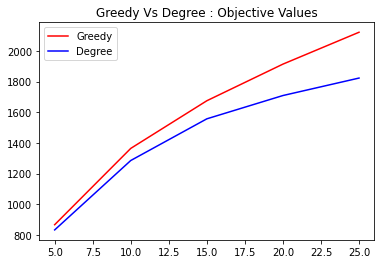

In [6]:
greedy_values = []
degree_values = []
for k in [5, 10, 15, 20, 25]:
    S = greedy_algorithm(G, k)
    greedy_values.append(N_S(G, S))
    S = degree_algorithm(G, k)
    degree_values.append(N_S(G, S))

plt.plot([5, 10, 15, 20, 25], greedy_values, color = 'red', label = "Greedy")
plt.plot([5, 10, 15, 20, 25], degree_values, color = 'blue', label = "Degree")
plt.legend(loc="upper left")
plt.title("Greedy Vs Degree : Objective Values")
plt.show()

### 2.3 Speedup the greedy algorithm 

Using the heap data structure we discussed in class, in order to speedup the implementation of the greedy algorithm. Call this variant of greedy **lazy greedy** and plot the running time of greedy and lazy greedy as a function of $k$. In a different figure also plot the value of the objective achieved by greedy and lazy greedy (just to make sure they are the same).

In [7]:
def lazy_greedy_algorithm(G, k):
    S = set()
    heap = []
    heapify(heap)
    
    #Store all marginal gains w.r.t the empty set
    for node in G.nodes:
        marginal_gain = len([neighbour for neighbour in G.neighbors(node)])
        heappush(heap, (-1 * marginal_gain, node))
    
    S.add(heappop(heap)[1])
    
    for iterations in range(1, k):
        max_node = heappop(heap)[1]
        second_max_node_gain =  -1 * heap[0][0]
        
        # Compute marginal gain of max_node
        F_S_0 = 0
        visited_neighbours = []
        for node in S:
            for neighbour in G.neighbors(node):
                if neighbour not in visited_neighbours:
                    visited_neighbours.append(neighbour)
                    F_S_0 += 1
    
        S.add(max_node)
        F_S_1 = 0
        visited_neighbours = []
        for node in S:
            for neighbour in G.neighbors(node):
                if neighbour not in visited_neighbours:
                    visited_neighbours.append(neighbour)
                    F_S_1 += 1
        S.discard(max_node)

        marginal_gain = F_S_1 - F_S_0

        # Comparison
        if marginal_gain >= second_max_node_gain:
            S.add(max_node)
    
        else:
            heappush(heap, (-1 * marginal_gain, max_node))
            selected_node = -1
            
            while(selected_node == -1):
                first_node = heappop(heap)[1]
                second_node_gain =  -1 * heap[0][0]
        
                # Compute marginal gain of first_node
                F_S_0 = 0
                visited_neighbours = []
                for node in S:
                    for neighbour in G.neighbors(node):
                        if neighbour not in visited_neighbours:
                            visited_neighbours.append(neighbour)
                            F_S_0 += 1
    
                S.add(first_node)
                F_S_1 = 0
                visited_neighbours = []
                for node in S:
                    for neighbour in G.neighbors(node):
                        if neighbour not in visited_neighbours:
                            visited_neighbours.append(neighbour)
                            F_S_1 += 1
                S.discard(first_node)

                marginal_gain = F_S_1 - F_S_0

                # Comparison
                if marginal_gain > second_node_gain:
                    selected_node = first_node  
                else:
                    heappush(heap, (-1 * marginal_gain, first_node))
            
            S.add(selected_node)
            
    return S

In [8]:
greedy_values = []
lazy_greedy_values = []
greedy_times = []
lazy_greedy_times = []
for k in range(1, 10):
    start = time.time()
    S = greedy_algorithm(G, k)
    greedy_times.append(time.time() - start)
    greedy_values.append(N_S(G, S))
    start = time.time()
    S = lazy_greedy_algorithm(G, k)
    lazy_greedy_times.append(time.time() - start)
    lazy_greedy_values.append(N_S(G, S))

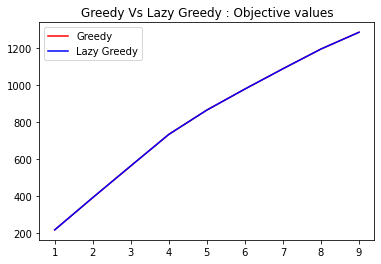

In [9]:
plt.plot(range(1, 10), greedy_values, color = 'red', label = "Greedy")
plt.plot(range(1, 10), lazy_greedy_values, color = 'blue', label = "Lazy Greedy")
plt.legend(loc="upper left")
plt.title("Greedy Vs Lazy Greedy : Objective values")
plt.show()

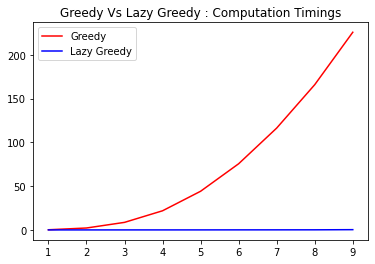

In [10]:
plt.plot(range(1, 10), greedy_times, color = 'red', label = "Greedy")
plt.plot(range(1, 10), lazy_greedy_times, color = 'blue', label = "Lazy Greedy")
plt.legend(loc="upper left")
plt.title("Greedy Vs Lazy Greedy : Computation Timings")
plt.show()